In [303]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ReLU, Input, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import cv2
import numpy as np
from glob import glob 
from keras import backend as K
from contextlib import redirect_stdout
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0


PATH = 'G:/Deletar/pictures_conv'
tf.random.set_seed(42) 
PRECISION = tf.float32
HEIGHT = 128
WIDTH = 128
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 1002


train_bw = glob("G:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
train_color = glob("G:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
test_bw = glob("G:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
test_color = glob("G:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg")

In [304]:
# apply black and white colors to image
def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH))
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/255., dtype=PRECISION)
    return img

def get_all_info(folder):
    imgs = []
    for file in os.listdir(folder):
        img_tensor = read_img(folder + "\\" + file) 
    return imgs

""" z = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw") """

files_ds = tf.data.Dataset.from_tensor_slices((train_bw, train_color))
files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE)
val_files = tf.data.Dataset.from_tensor_slices((test_bw, test_color))
val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)

example = list(files_ds.as_numpy_iterator())
example2 = list(val_files.as_numpy_iterator())

In [305]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    """ result.add(      
     Conv2D(tf.keras.layers.Conv2D(filters, kernel_size = size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))) """
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
      if epoch % 5 == 0: 
        z = self.model.predict(example[0][0])
        plt.imshow(z[0])
        plt.show()
        

Epoch 1/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0367 - accuracy: 0.5161 - val_loss: 0.0229 - val_accuracy: 0.5546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


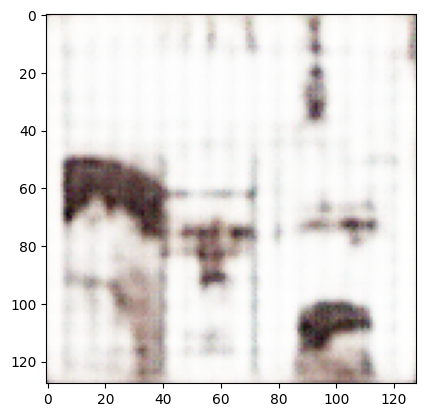

Epoch 2/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0185 - accuracy: 0.5697 - val_loss: 0.0155 - val_accuracy: 0.6100
Epoch 3/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0163 - accuracy: 0.5788 - val_loss: 0.0139 - val_accuracy: 0.5972
Epoch 4/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0150 - accuracy: 0.5795 - val_loss: 0.0125 - val_accuracy: 0.5994
Epoch 5/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0143 - accuracy: 0.5838 - val_loss: 0.0143 - val_accuracy: 0.6167
Epoch 6/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0138 - accuracy: 0.5797 - val_loss: 0.0140 - val_accuracy: 0.5627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


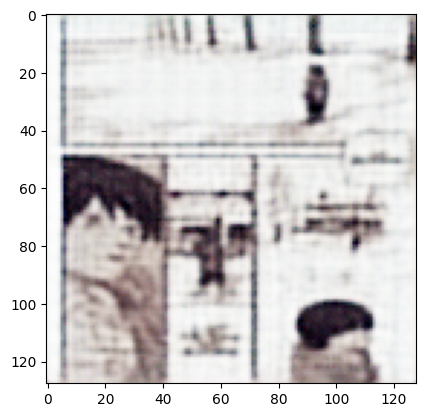

Epoch 7/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0132 - accuracy: 0.5797 - val_loss: 0.0123 - val_accuracy: 0.6000
Epoch 8/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0129 - accuracy: 0.5809 - val_loss: 0.0124 - val_accuracy: 0.6162
Epoch 9/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0126 - accuracy: 0.5811 - val_loss: 0.0150 - val_accuracy: 0.5165
Epoch 10/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0125 - accuracy: 0.5830 - val_loss: 0.0116 - val_accuracy: 0.5736
Epoch 11/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0121 - accuracy: 0.5813 - val_loss: 0.0123 - val_accuracy: 0.5224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


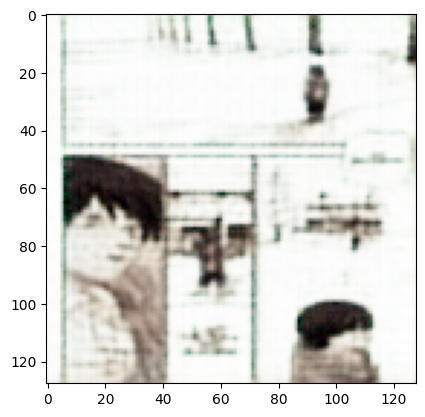

Epoch 12/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0120 - accuracy: 0.5785 - val_loss: 0.0105 - val_accuracy: 0.5793
Epoch 13/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0120 - accuracy: 0.5794 - val_loss: 0.0117 - val_accuracy: 0.5872
Epoch 14/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0116 - accuracy: 0.5843 - val_loss: 0.0127 - val_accuracy: 0.6183
Epoch 15/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0115 - accuracy: 0.5811 - val_loss: 0.0104 - val_accuracy: 0.5541
Epoch 16/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0114 - accuracy: 0.5807 - val_loss: 0.0108 - val_accuracy: 0.6095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


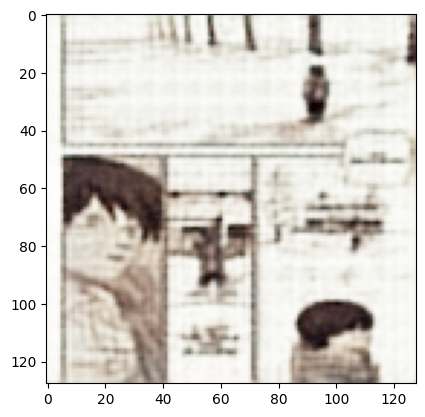

Epoch 17/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0114 - accuracy: 0.5816 - val_loss: 0.0107 - val_accuracy: 0.5654
Epoch 18/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0112 - accuracy: 0.5811 - val_loss: 0.0106 - val_accuracy: 0.4999
Epoch 19/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0110 - accuracy: 0.5804 - val_loss: 0.0102 - val_accuracy: 0.5876
Epoch 20/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0110 - accuracy: 0.5819 - val_loss: 0.0112 - val_accuracy: 0.5377
Epoch 21/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0109 - accuracy: 0.5787 - val_loss: 0.0103 - val_accuracy: 0.5905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


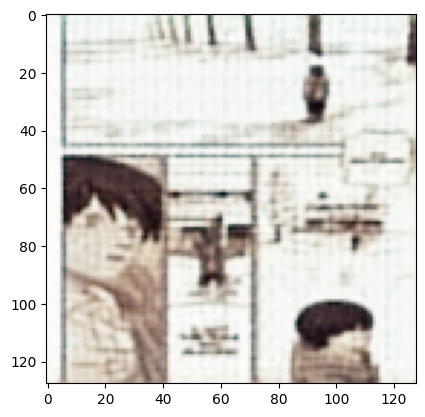

Epoch 22/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0108 - accuracy: 0.5817 - val_loss: 0.0105 - val_accuracy: 0.4613
Epoch 23/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0108 - accuracy: 0.5796 - val_loss: 0.0102 - val_accuracy: 0.5925
Epoch 24/200
496/496 [==============================] - 6s 11ms/step - loss: 0.0106 - accuracy: 0.5839 - val_loss: 0.0096 - val_accuracy: 0.5902


In [306]:
initializer = tf.random_normal_initializer(0., 0.02)

# improvements
# insert layer kernel_regularizer='l1'
# insert layer kernel_regularizer='l2'

model = Sequential()
model.add(Input(shape=(HEIGHT, WIDTH, 3,)))

#Encoder
""" model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4)) """


""" model.add(downsample(512,4, apply_batchnorm=False))
model.add(downsample(512,4))
model.add(downsample(512,4)) """
model.add(downsample(128,4, apply_batchnorm=False))
model.add(downsample(64,4))
model.add(downsample(32,4))







""" model.add(downsample(1024,4, apply_batchnorm=False)) #best """






#Decoder
""" model.add(upsample(512,4, apply_dropout=True))
model.add(upsample(512,4, apply_dropout=True)) """

model.add(upsample(128,4))
model.add(upsample(256,4))





""" model.add(upsample(256,4, apply_dropout=True)) """
""" model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))  """

model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))






model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer= tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    metrics=["accuracy"]    
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)



model.fit(files_ds,epochs=200, callbacks=[CustomCallback(model, files_ds), callback], validation_data=val_files)




 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


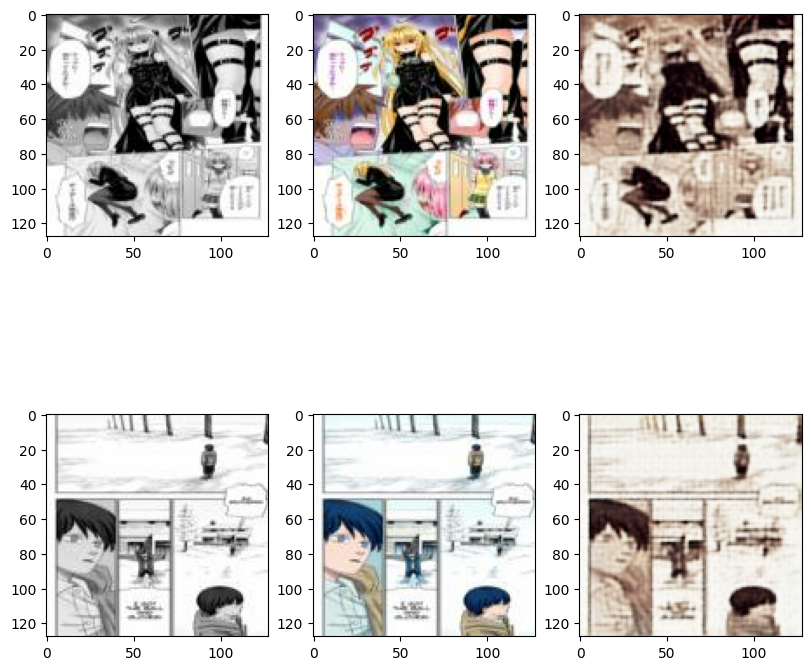

In [307]:
test_img_pred = model.predict(example2[0][0])[0]
train_img_pred = model.predict(example[0][0])[0]

f, axarr = plt.subplots(2,3, figsize=(8, 8), constrained_layout=True)
axarr[0,0].imshow(example2[0][0][0])
axarr[0,1].imshow(example2[0][1][0])
axarr[0,2].imshow(test_img_pred)
 
axarr[1,0].imshow(example[0][0][0])
axarr[1,1].imshow(example[0][1][0])
axarr[1,2].imshow(train_img_pred)

In [308]:
#comments

""" model = Sequential([
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_01'),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_01'),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_02'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_02'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_03'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_04'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_04'),
    Dropout(0.5),
    Activation('relu', name='relu_04'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_05'),
    Dropout(0.5),
    Activation('relu', name='relu_05'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_06'),
    Activation('relu', name='relu_06'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same'),
    Activation('tanh'),    
]) """

# model.add(Input(shape=[HEIGHT, WIDTH, 3]))

""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(upsample(128,4, apply_dropout=True)) """

""" model = Sequential()
model.add(downsample(64,9, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(upsample(128,4, apply_dropout=True))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """

""" model.add(downsample(128,4)) """
""" model.add(downsample(256,4)) """
""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(128,4)) """
""" model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) """

""" model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


""" model.add(upsample(128,4, apply_dropout=True))
model.add(upsample(128,4, apply_dropout=True)) """
""" model.add(upsample(128,4))
model.add(upsample(128,4)) """
""" model.add(upsample(256,4, apply_dropout=True)) """
""" model.add(upsample(128,4)) """


""" 
model.add(UpSampling2D((2, 2))) """

""" encoder_output = (encoder_input)



decoder_output = (encoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output) """


' encoder_output = (encoder_input)\n\n\n\ndecoder_output = (encoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output) '